# Image Classification Model #

Using the [Medeley dataset](https://data.mendeley.com/datasets/rscbjbr9sj/3) which is composed of chest X-ray images consisting of patients with Normal lungs and patients with Pneumonia, some Convolutional Neural Networks were created to predict whether a patient had Pneumonia or not.

This notebook has the objective of creating a series of networks that iteratively increases model performance. The main metric used to evaluate model performance was Recall.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
path_to_src = os.path.join('../', 'src')
sys.path.insert(0, path_to_src)
from functions import *
%matplotlib inline

### Splitting the data ###

In this dataset we have a training and testing directories. We will be using the testing directory as our holdout validation data (data we will use to validate out model), and the training directory as our main train/test data.

In [3]:
data_dir_train = '../data/train/'
data_dir_test = '../data/test/'
categories = ['NORMAL', 'PNEUMONIA']

Let's output one of the images of our training data.

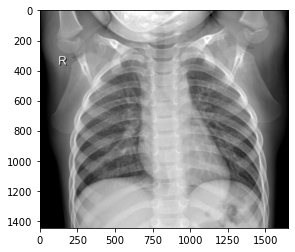

In [4]:
for category in categories:
    path_train = os.path.join(data_dir_train,category)
    for img in os.listdir(path_train):
        img_array_train = cv2.imread(os.path.join(path_train,img))
        plt.imshow(img_array_train, cmap="gray")
        plt.show()
        break
    break

Now let's output one of our images from our testing (holdout data).

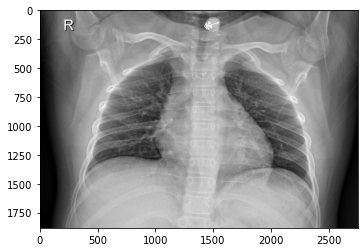

In [5]:
for category in categories:
    path_test = os.path.join(data_dir_test,category)
    for img in os.listdir(path_test):
        img_array_test = cv2.imread(os.path.join(path_test,img))
        plt.imshow(img_array_test, cmap="gray")
        plt.show()
        break
    break

Let's see the img array shape

In [6]:
print(img_array_train.shape)
print(img_array_test.shape)

(1446, 1654, 3)
(1882, 2752, 3)


We don't want to bog down our model, therefore let's resize our image to a smaller resolution to provide efficiency and streamline the inputs into the model.

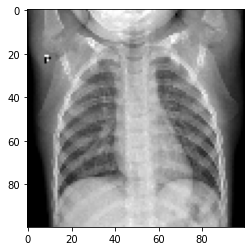

In [7]:
img_size = 100
train_array = cv2.resize(img_array_train,(img_size, img_size))
plt.imshow(train_array, cmap = 'gray')
plt.show()

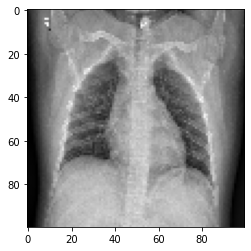

In [8]:
test_array = cv2.resize(img_array_test, (img_size, img_size))
plt.imshow(test_array, cmap = 'gray')
plt.show()

### Creating our datasets ###

In [9]:
train_data = []
test_data = []

Defining our functions to create our datasets for training and testing.

In [10]:
def create_training_data():
    """
    Using a for loop, the images in data_dir_train and the labels in category are appended to train_data to
    create our training data set.
    """
    for category in categories:
        path_train = os.path.join(data_dir_train,category)
        class_num = categories.index(category)
        for img in os.listdir(path_train):
            try:
                img_array_train = cv2.imread(os.path.join(path_train,img))
                train_array = cv2.resize(img_array_train,(img_size, img_size))
                train_data.append([train_array, class_num])
            except Exception as e:
                pass
            
            
def create_testing_data():
    """
    Using a for loop, the images in data_dir_test and the labels in category are appended to test_data to
    create our testing data set.
    """
    for category in categories:
        path_test = os.path.join(data_dir_test,category)
        class_num = categories.index(category)
        for img in os.listdir(path_test):
            try:
                img_array_test = cv2.imread(os.path.join(path_test,img))
                test_array = cv2.resize(img_array_test,(img_size, img_size))
                test_data.append([test_array, class_num])
            except Exception as e:
                pass

In [11]:
create_training_data()
create_testing_data()

Let's check the size length of the training and test data.

In [12]:
print('Training data count: {}'.format(len(train_data)))
print('Testing data count: {}'.format(len(test_data)))

Training data count: 5232
Testing data count: 624


In [13]:
random.shuffle(train_data)

In [14]:
random.shuffle(test_data)

Checking on the outputs of the labels per dataset.

In [15]:
for sample in train_data[:5]:
    print('Train array', sample[0])
    print('Train label', sample[1])
    
    
for sample in test_data[:5]:
    print('Testing array', sample[0])
    print('Testing label', sample[1])

Train array [[[137 137 137]
  [140 140 140]
  [133 133 133]
  ...
  [ 80  80  80]
  [ 98  98  98]
  [117 117 117]]

 [[139 139 139]
  [146 146 146]
  [133 133 133]
  ...
  [ 98  98  98]
  [120 120 120]
  [114 114 114]]

 [[133 133 133]
  [139 139 139]
  [128 128 128]
  ...
  [102 102 102]
  [ 82  82  82]
  [ 51  51  51]]

 ...

 [[  9   9   9]
  [ 10  10  10]
  [ 14  14  14]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  4   4   4]
  [  4   4   4]
  [  4   4   4]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 31  31  31]
  [233 233 233]
  [  2   2   2]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
Train label 1
Train array [[[160 160 160]
  [156 156 156]
  [159 159 159]
  ...
  [ 30  30  30]
  [ 41  41  41]
  [ 29  29  29]]

 [[157 157 157]
  [154 154 154]
  [161 161 161]
  ...
  [ 38  38  38]
  [ 24  24  24]
  [ 31  31  31]]

 [[153 153 153]
  [154 154 154]
  [162 162 162]
  ...
  [ 19  19  19]
  [ 33  33  33]
  [ 21  21  21]]

 ...

 [[168 168 168

Now it's time to split our data into its features and labels for both our training dataset and the testing (holdout) dataset.

In [16]:
X = []
y = []

In [17]:
Xtest = []
ytest = []

In [18]:
for features, label in train_data:
    X.append(features)
    y.append(label)

In [19]:
for features, label in test_data:
    Xtest.append(features)
    ytest.append(label)

### Converting our images into Numpy Arrays ###

In order for our models to take the data of all of our images we will streamline image to a numpy array. Our image array should be size 100,100 and have 3 channels

Our training dataset should be n-size (in this case `X: 5232` and `Xtest: 624`).

We also normalize our data by dividing the array values by 255 since pixel values go from 0-255.

In [20]:
X = np.array(X)

In [21]:
X.shape

(5232, 100, 100, 3)

In [22]:
X = X/255.0

Let's do the same to our testing dataset.

In [23]:
Xtest = np.array(Xtest)

In [24]:
Xtest.shape

(624, 100, 100, 3)

In [25]:
Xtest = Xtest/255.0

### Splitting our training dataset into our train and testing set ###

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=40)

In [27]:
X_train.shape

(3924, 100, 100, 3)

Let's encode our labels for the training and holdout dataset.

In [28]:
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [29]:
y_train = np.array(y_train)
y_test = np.array(y_test)

Encoding our testing/holdout dataset.

In [30]:
ytest = keras.utils.to_categorical(ytest, num_classes)

In [31]:
ytest = np.array(ytest)

Let's see the shape of our split data and the holdout dataset before we fit and evaluate our models.

In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3924, 100, 100, 3)
(3924, 2)
(1308, 100, 100, 3)
(1308, 2)


In [33]:
print(Xtest.shape)
print(ytest.shape)

(624, 100, 100, 3)
(624, 2)


In [34]:
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (3924, 100, 100, 3)
3924 train samples
1308 test samples


# Baseline Model #

Let's build our first model. We will not add too many layers just the basics and see how it performs on our Recall.

In [35]:
base_line = Sequential()
base_line.add(Conv2D(32, kernel_size= 5, activation='relu', padding='same', input_shape=(100, 100, 3)))
base_line.add(MaxPooling2D(2,2))
base_line.add(Flatten())
base_line.add(Dense(16, activation='relu'))
base_line.add(Dense(2, activation='sigmoid'))

We added a Convolutional layer with 32 filters, 5x5 convolutional window. Because the input of the image arrays are 100,100,3 we are going to be specifying that `input_size`. For the last layer we will be using a Dense layer using only 2 filers as our categories of images are only 2 as will as an activation function of `sigmoid`.

In [36]:
base_line.compile(loss="binary_crossentropy", optimizer="adam", metrics = [Precision(), Recall()])


In [37]:
base_line.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1280016   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 1,282,482
Trainable params: 1,282,482
Non-trainable params: 0
_________________________________________________________________


It's time to see how our first model performs.

Let's fit our training data into our model using our test data from the train test split as our validation data. We will also time our model and see how long it took to run our model with our data.

In [38]:
start = time.time()
history_baseline = base_line.fit(X_train,
                                 y_train,
                                 batch_size = 32,
                                 epochs = 5,
                                 validation_data = (X_test, y_test))
end = time.time()
print('------------------------------------------------')
print('This model took {} minutes to train.'.format((end-start)/60))

Epoch 1/5
123/123 [==============================] - 38s 130ms/step - loss: 0.4282 - precision: 0.7990 - recall: 0.8452 - val_loss: 0.1236 - val_precision: 0.9612 - val_recall: 0.9648
Epoch 2/5
123/123 [==============================] - 14s 117ms/step - loss: 0.1413 - precision: 0.9442 - recall: 0.9498 - val_loss: 0.0963 - val_precision: 0.9605 - val_recall: 0.9656
Epoch 3/5
123/123 [==============================] - 15s 121ms/step - loss: 0.0813 - precision: 0.9675 - recall: 0.9706 - val_loss: 0.0947 - val_precision: 0.9662 - val_recall: 0.9610
Epoch 4/5
123/123 [==============================] - 15s 122ms/step - loss: 0.0842 - precision: 0.9695 - recall: 0.9721 - val_loss: 0.0858 - val_precision: 0.9666 - val_recall: 0.9740
Epoch 5/5
123/123 [==============================] - 15s 122ms/step - loss: 0.0522 - precision: 0.9799 - recall: 0.9823 - val_loss: 0.0889 - val_precision: 0.9739 - val_recall: 0.9702
------------------------------------------------
This model took 1.6301427523295

It appears as though our model learned from our data through all the epochs.

Let's visualize our model performance. 

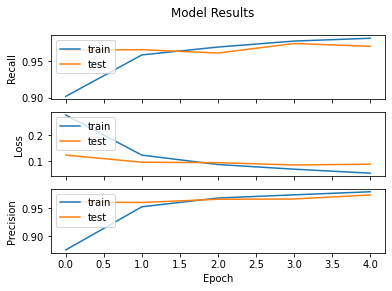

<Figure size 432x288 with 0 Axes>

In [111]:
visualize_training_results_1(history_baseline)
plt.savefig('../images/baseline_model')

In [40]:
results_train = base_line.evaluate(X_train, y_train)
results_test = base_line.evaluate(X_test, y_test)

41/41 [==============================] - 1s 29ms/step - loss: 0.0889 - precision: 0.9739 - recall: 0.9702


In [41]:
print("%s: %.2f%%" % (base_line.metrics_names[2], results_train[2]*100))
print("%s: %.2f%%" % (base_line.metrics_names[2], results_test[2]*100))

recall: 98.98%
recall: 97.02%


Based on this preliminary model performance it does seem that our model performed very well. There was some overfitting, gradual loss on the training and validation data, and our precision was on par with our recall score.

# Model 2 #

For our second model, we will not be going too deep. We will be mainly be adding more Filters in our Conv2D and add an extra Dense layer.

In [42]:
model_2 = Sequential()
model_2.add(Conv2D(128, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,3)))
model_2.add(MaxPooling2D(4,4))
model_2.add(Flatten())
model_2.add(Dense(32, activation = 'relu'))
model_2.add(Dense(16, activation = 'relu'))
model_2.add(Dense(2, activation = 'sigmoid'))

In [43]:
model_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [44]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 128)     9728      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2560032   
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 2,570,322
Trainable params: 2,570,322
Non-trainable params: 0
____________________________________________

It's time to fit.

In [45]:
start = time.time()
history_model_2 = model_2.fit(X_train,
                              y_train,
                              batch_size = 32,
                              epochs = 5,
                              validation_data = (X_test,y_test))
end = time.time()
print('------------------------------------------------')
print('This model took {} minutes to train.'.format((end-start)/60))

Epoch 1/5
123/123 [==============================] - 39s 297ms/step - loss: 0.4297 - precision_1: 0.8444 - recall_1: 0.7812 - val_loss: 0.1182 - val_precision_1: 0.9588 - val_recall_1: 0.9610
Epoch 2/5
123/123 [==============================] - 34s 279ms/step - loss: 0.1165 - precision_1: 0.9567 - recall_1: 0.9554 - val_loss: 0.0873 - val_precision_1: 0.9726 - val_recall_1: 0.9755
Epoch 3/5
123/123 [==============================] - 23s 188ms/step - loss: 0.0976 - precision_1: 0.9653 - recall_1: 0.9661 - val_loss: 0.1050 - val_precision_1: 0.9617 - val_recall_1: 0.9587
Epoch 4/5
123/123 [==============================] - 23s 189ms/step - loss: 0.0644 - precision_1: 0.9773 - recall_1: 0.9789 - val_loss: 0.0886 - val_precision_1: 0.9733 - val_recall_1: 0.9763
Epoch 5/5
123/123 [==============================] - 23s 190ms/step - loss: 0.0544 - precision_1: 0.9822 - recall_1: 0.9816 - val_loss: 0.0919 - val_precision_1: 0.9739 - val_recall_1: 0.9717
----------------------------------------

It appears as though our model perfomed well as well, on par of our first model.

Let's visualize our model performance.

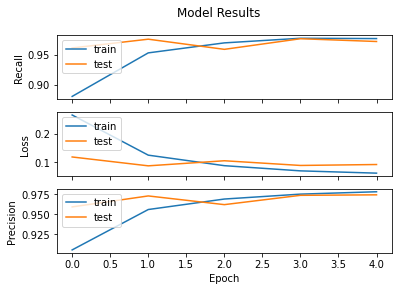

<Figure size 432x288 with 0 Axes>

In [112]:
visualize_training_results(history_model_2,1)
plt.savefig('../images/model_2')

In [47]:
results_train = model_2.evaluate(X_train, y_train)
results_test = model_2.evaluate(X_test, y_test)

41/41 [==============================] - 2s 43ms/step - loss: 0.0919 - precision_1: 0.9739 - recall_1: 0.9717


In [48]:
print("Train %s: %.2f%%" % (model_2.metrics_names[2], results_train[2]*100))
print("Test %s: %.2f%%" % (model_2.metrics_names[2], results_test[2]*100))

Train recall_1: 98.09%
Test recall_1: 97.17%


Based on our model metrics, it appears as though we are getting slightly more overfitting. So far both our models have been running through our data in under 5 minutes. Thereofore based on the time that the model takes to fit into our data and the model metrics, we can say that we have a great couple of models.

# Model 3 #

It is now time to go a little deeper with our models. This time to prevent some overfitting in our model, we will be adding some dropout in our data. We will also be increasing our filter sizes and adding multiple Dense layers.

In [49]:
model_3 = Sequential()
model_3.add(Conv2D(256, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,3)))
model_3.add(Dense(128, activation = 'relu'))
model_3.add(MaxPooling2D(4,4))
model_3.add(Dropout(.20))
model_3.add(Dense(64, activation='relu'))
model_3.add(Flatten())
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dense(16, activation = 'relu'))
model_3.add(Dense(16, activation = 'sigmoid'))
model_3.add(Dense(2, activation = 'sigmoid'))

In [50]:
model_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [51]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 100, 256)     19456     
_________________________________________________________________
dense_5 (Dense)              (None, 100, 100, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 128)       0         
_________________________________________________________________
dense_6 (Dense)              (None, 25, 25, 64)        8256      
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [52]:
start = time.time()
history_model_3 = model_3.fit(X_train,
                              y_train,
                              batch_size= 64,
                              epochs = 10,
                              validation_data = (X_test, y_test))

end = time.time()
print('------------------------------------------------')
print('This model took {} minutes to train.'.format((end-start)/60))

Epoch 1/10
62/62 [==============================] - 72s 1s/step - loss: 0.5608 - precision_2: 0.7485 - recall_2: 0.7485 - val_loss: 0.5257 - val_precision_2: 0.7362 - val_recall_2: 0.7362
Epoch 2/10
62/62 [==============================] - 70s 1s/step - loss: 0.4928 - precision_2: 0.7443 - recall_2: 0.7443 - val_loss: 0.4647 - val_precision_2: 0.7362 - val_recall_2: 0.7362
Epoch 3/10
62/62 [==============================] - 70s 1s/step - loss: 0.4325 - precision_2: 0.7503 - recall_2: 0.7505 - val_loss: 0.3942 - val_precision_2: 0.7362 - val_recall_2: 0.7362
Epoch 4/10
62/62 [==============================] - 70s 1s/step - loss: 0.3766 - precision_2: 0.7465 - recall_2: 0.7465 - val_loss: 0.3466 - val_precision_2: 0.7362 - val_recall_2: 0.7362
Epoch 5/10
62/62 [==============================] - 70s 1s/step - loss: 0.3449 - precision_2: 0.8094 - recall_2: 0.8064 - val_loss: 0.3832 - val_precision_2: 0.9340 - val_recall_2: 0.9304
Epoch 6/10
62/62 [==============================] - 74s 1s/s

Overall it appears that our model perfomed great. having a recall of 97 for our testing data.

Let's visualize.

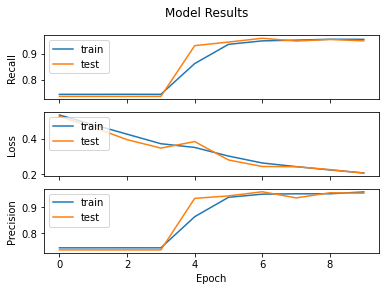

<Figure size 432x288 with 0 Axes>

In [113]:
visualize_training_results(history_model_3, 2)
plt.savefig('../images/model_3')

There appears to be slight overfitting by the eighth epoch in our precision. Otherwise, great learning slope.

In [54]:
results_train = model_3.evaluate(X_train, y_train)
results_test = model_3.evaluate(X_test, y_test)

41/41 [==============================] - 7s 181ms/step - loss: 0.2049 - precision_2: 0.9539 - recall_2: 0.9488


In [55]:
print("Train %s: %.2f%%" % (model_3.metrics_names[2], results_train[1]*100))
print("Test %s: %.2f%%" % (model_3.metrics_names[2], results_test[1]*100))

Train recall_2: 95.76%
Test recall_2: 95.39%


Great scores. There does not appear to be overfitting.

It is now time to save our model to a yaml file and use the Xtest data (our holdout data) to validate our model.

In [56]:
#pip install pyyaml

Note: you may need to restart the kernel to use updated packages.


In [57]:
model_yaml = model_3.to_yaml()
with open("model_3.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_3.save_weights("model_3.h5")
print("Saved model to disk")

Saved model to disk


In [58]:
yaml_file = open('model_3.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_3.h5")
print("Loaded model from disk")

Loaded model from disk


In [59]:
loaded_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [60]:
score = loaded_model.evaluate(Xtest, ytest)
print('------------------------------------')
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))

20/20 [==============================] - 4s 177ms/step - loss: 0.3581 - precision_3: 0.8826 - recall_3: 0.8798
------------------------------------
recall_3: 88.30%


Overall a solid number. However, it is important to point out that there was an 8 point dropoff from our test data recall metric.

# Model 4 #

Let's go even deeper. This time we will be adding 2 Dropout layers and increasing our filters as well. we will also be adding 2 more Conv2D layers to see if we can improve model performace.

In [61]:
model_4 = Sequential()
model_4.add(Conv2D(256, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,3)))
model_4.add(Dense(128, activation = 'tanh'))
model_4.add(MaxPooling2D(2,2))
model_4.add(Conv2D(128, kernel_size = 4, activation = 'relu'))
model_4.add(MaxPooling2D(4,4))
model_4.add(Dropout(.20))
model_4.add(Dense(64, activation = 'relu'))
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dropout(.20))
model_4.add(Conv2D(64, kernel_size=5, activation='sigmoid', padding='same'))
model_4.add(MaxPooling2D(4,4))
model_4.add(Flatten())
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(16, activation = 'tanh'))
model_4.add(Dense(2, activation = 'sigmoid'))

In [62]:
model_4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [63]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 256)     19456     
_________________________________________________________________
dense_11 (Dense)             (None, 100, 100, 128)     32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 128)       262272    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
dense_12 (Dense)             (None, 11, 11, 64)       

In [64]:
start = time.time()
history_model_4 = model_4.fit(X_train,
                              y_train,
                              batch_size = 64,
                              epochs = 15,
                              validation_data = (X_test, y_test))
end = time.time()
print('------------------------------------------------')
print('This model took {} minutes to train.'.format((end-start)/60))

Epoch 1/15
62/62 [==============================] - 122s 2s/step - loss: 0.5835 - precision_4: 0.7270 - recall_4: 0.6844 - val_loss: 0.5518 - val_precision_4: 0.7362 - val_recall_4: 0.7362
Epoch 2/15
62/62 [==============================] - 122s 2s/step - loss: 0.4867 - precision_4: 0.7783 - recall_4: 0.7608 - val_loss: 0.3153 - val_precision_4: 0.8716 - val_recall_4: 0.8716
Epoch 3/15
62/62 [==============================] - 121s 2s/step - loss: 0.2812 - precision_4: 0.8881 - recall_4: 0.8898 - val_loss: 0.1703 - val_precision_4: 0.9447 - val_recall_4: 0.9411
Epoch 4/15
62/62 [==============================] - 125s 2s/step - loss: 0.2091 - precision_4: 0.9145 - recall_4: 0.9143 - val_loss: 0.1585 - val_precision_4: 0.9477 - val_recall_4: 0.9427
Epoch 5/15
62/62 [==============================] - 119s 2s/step - loss: 0.1626 - precision_4: 0.9419 - recall_4: 0.9380 - val_loss: 0.1382 - val_precision_4: 0.9443 - val_recall_4: 0.9465
Epoch 6/15
62/62 [==============================] - 118

This model did not appear to improve model performance in fact it performed a bit worse from the first 3 models.

Let's visualize.

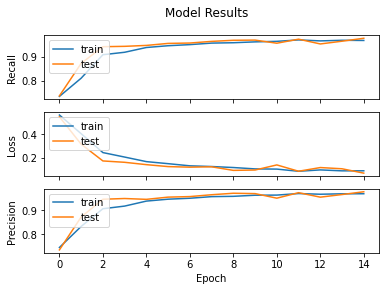

<Figure size 432x288 with 0 Axes>

In [114]:
visualize_training_results(history_model_4, 4)
plt.savefig('../images/model_4')

In [66]:
results_train = model_4.evaluate(X_train, y_train)
results_test = model_4.evaluate(X_test, y_test)

41/41 [==============================] - 10s 253ms/step - loss: 0.0647 - precision_4: 0.9756 - recall_4: 0.9763


In [67]:
print("Train %s: %.2f%%" % (model_4.metrics_names[2], results_train[2]*100))
print("Test %s: %.2f%%" % (model_4.metrics_names[2], results_test[2]*100))

Train recall_4: 98.32%
Test recall_4: 97.63%


In [68]:
model_yaml = model_4.to_yaml()
with open("model_4.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_4.save_weights("model_4.h5")
print("Saved model to disk")

Saved model to disk


In [69]:
yaml_file = open('model_4.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_4.h5")
print("Loaded model from disk")

Loaded model from disk


In [70]:
loaded_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [71]:
score = loaded_model.evaluate(Xtest, ytest)
print('------------------------------------')
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))

20/20 [==============================] - 6s 258ms/step - loss: 0.4664 - precision_5: 0.8302 - recall_5: 0.8292
------------------------------------
recall_5: 84.78%


Overall though, we can say that our model performance using the validation data, there was a pretty huge dropoff in model performance.

Considering this and the fact that this model took a very long time to run, this would not be the best model to choose as our best performing.

# Model Explanation #

In order to see what our Neural Network models "see" when we pass our images through them, we will use package `lime`. See [here for package documentation](https://github.com/marcotcr/lime).

This package was created by `marcotcr`.

We will choose the 2nd image of each dataset (including X_train, X_test, and Xtest).

In [73]:
image_1 = X_train[1]

In [115]:
label = y_train[1]

In [118]:
print('image_1 shape:',image_1.shape)
print('image_1:', image_1)
print('image_1 label:',label)

image_1 shape: (100, 100, 3)
image_1: [[[0.34509804 0.34509804 0.34509804]
  [0.41568627 0.41568627 0.41568627]
  [0.41960784 0.41960784 0.41960784]
  ...
  [0.1372549  0.1372549  0.1372549 ]
  [0.07843137 0.07843137 0.07843137]
  [0.         0.         0.        ]]

 [[0.32941176 0.32941176 0.32941176]
  [0.4        0.4        0.4       ]
  [0.4        0.4        0.4       ]
  ...
  [0.11372549 0.11372549 0.11372549]
  [0.00784314 0.00784314 0.00784314]
  [0.         0.         0.        ]]

 [[0.31372549 0.31372549 0.31372549]
  [0.40392157 0.40392157 0.40392157]
  [0.40784314 0.40784314 0.40784314]
  ...
  [0.08235294 0.08235294 0.08235294]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]

It appaers that this picture is a NORMAL lung X-ray. we can tell by the label.

Let's see the image.

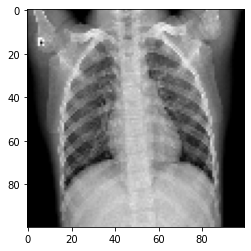

In [75]:
plt.imshow(image_1)
plt.savefig('../images/first_image')

In [76]:
explainer = lime_image.LimeImageExplainer()

We will expand the dimension in order for the image to be able to be passed onto our model.

In [77]:
image_1_expanded = np.expand_dims(image_1,axis=0)

In [78]:
image_1_expanded[0].shape

(100, 100, 3)

Let's create our explanation.

In [79]:
explanation = explainer.explain_instance(image_1_expanded[0].astype('double'), model_3.predict,
                                         top_labels=5, hide_color=0, num_samples = 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Now let's visualize our explanation. The portion of the image that is not blackened is the portion of the image that is contributing the most to the classification that the model is outputting.

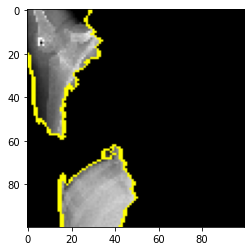

In [83]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2,
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/first_image_top_pixels_blackened')

The output of the image below shows the same yellow border as the image above just not blackened.

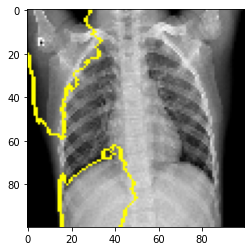

In [84]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/first_image_top_pixels_unblackened')

 As we can see below we can visualize the pros and cons (pros in green, cons in red).

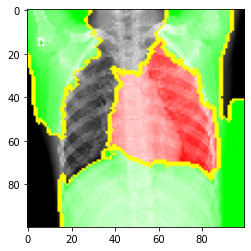

In [86]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/first_image_pros_cons')

We can also see the weights of the explanation of our model. The colorbar shows the values of the weights.

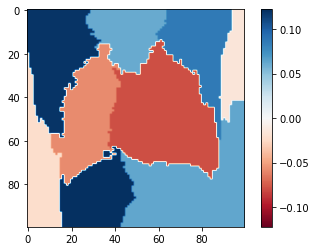

In [87]:
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.savefig('../images/first_image_heatmap')

## Second Image ##

We will perform the same preprocessing methods as the first image.

In [119]:
image_2 = X_test[1]
label_2 = y_test[1]

In [120]:
print('image_2 shape:',image_2.shape)
print('image_2:', image_2)
print('image_2 label:',label_2)

image_2 shape: (100, 100, 3)
image_2: [[[0.71764706 0.71764706 0.71764706]
  [0.67058824 0.67058824 0.67058824]
  [0.7372549  0.7372549  0.7372549 ]
  ...
  [0.34901961 0.34901961 0.34901961]
  [0.36470588 0.36470588 0.36470588]
  [0.35686275 0.35686275 0.35686275]]

 [[0.44705882 0.44705882 0.44705882]
  [0.42745098 0.42745098 0.42745098]
  [0.49803922 0.49803922 0.49803922]
  ...
  [0.23921569 0.23921569 0.23921569]
  [0.21176471 0.21176471 0.21176471]
  [0.18431373 0.18431373 0.18431373]]

 [[0.26666667 0.26666667 0.26666667]
  [0.28235294 0.28235294 0.28235294]
  [0.30196078 0.30196078 0.30196078]
  ...
  [0.20392157 0.20392157 0.20392157]
  [0.21568627 0.21568627 0.21568627]
  [0.20392157 0.20392157 0.20392157]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.18823529 0.18823529 0.18823529]
  [0.05490196 0.05490196 0.05490196]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]

It appears that our image is a NORMAL lung X-Ray. We can tell based on the label.

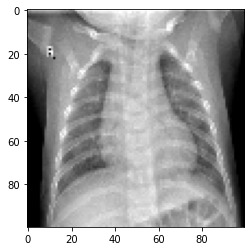

In [90]:
plt.imshow(image_2)
plt.savefig('../images/second_image')

In [91]:
image_2_expanded = np.expand_dims(image_2,axis=0)

In [92]:
image_2_expanded[0].shape

(100, 100, 3)

In [93]:
model_3.predict(image_2_expanded)

array([[0.74252534, 0.24458745]], dtype=float32)

Time to get our explanation.

In [94]:
explanation_2 = explainer.explain_instance(image_2_expanded[0].astype('double'), model_3.predict,
                                         top_labels=5, hide_color=0, num_samples = 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

The image below shows the top 2 "pixels" that the computer is "seeing" for the NORMAL categorization in this image.

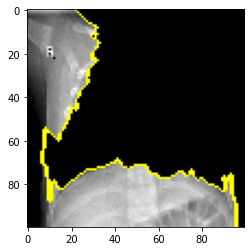

In [96]:
temp, mask = explanation_2.get_image_and_mask(explanation_2.top_labels[0], positive_only=True, num_features=2,
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/second_image_top_pixels_blackened')

This image is shows the whole picture just segmented.

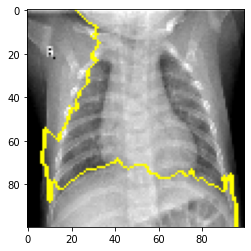

In [97]:
temp, mask = explanation_2.get_image_and_mask(explanation_2.top_labels[0], positive_only=True, num_features=2, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/second_image_top_pixels_unblackened')

This image shows 5 features and colors green for pro and red for cons for the category this picture is.

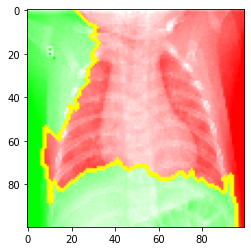

In [125]:
temp, mask = explanation_2.get_image_and_mask(explanation_2.top_labels[0], 
                                            positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/second_image_pros_cons')

Finally, This is the heatmap of the explanation weights with blue being the most heavy and red being the least heavy.

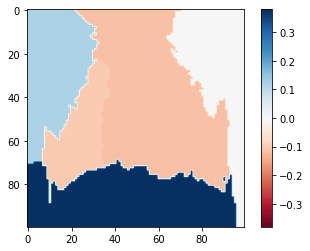

In [99]:
ind =  explanation_2.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_2.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_2.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.savefig('../images/second_image_heatmap')

## Image 3

The same preprocess being performed as the 2 images before.

In [122]:
image_3 = Xtest[1]
label_3 = ytest[1]

In [123]:
print('image_3 shape:',image_3.shape)
print('image_3:', image_3)
print('image_3 label:',label_3)

image_3 shape: (100, 100, 3)
image_3: [[[0.00392157 0.00392157 0.00392157]
  [0.72941176 0.72941176 0.72941176]
  [0.74509804 0.74509804 0.74509804]
  ...
  [0.75294118 0.75294118 0.75294118]
  [0.75686275 0.75686275 0.75686275]
  [0.81568627 0.81568627 0.81568627]]

 [[0.         0.         0.        ]
  [0.6745098  0.6745098  0.6745098 ]
  [0.68235294 0.68235294 0.68235294]
  ...
  [0.75294118 0.75294118 0.75294118]
  [0.76078431 0.76078431 0.76078431]
  [0.79607843 0.79607843 0.79607843]]

 [[0.55686275 0.55686275 0.55686275]
  [0.60784314 0.60784314 0.60784314]
  [0.59607843 0.59607843 0.59607843]
  ...
  [0.62745098 0.62745098 0.62745098]
  [0.61960784 0.61960784 0.61960784]
  [0.66666667 0.66666667 0.66666667]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.05098039 0.05098039 0.05098039]
  [0.01960784 0.01960784 0.01960784]
  [0.00392157 0.00392157 0.00392157]]

 [[0.00392157 0.00392157 0.00392157]

This image appears to be a NORMAL lung X-Ray image. We can tell based on the label.

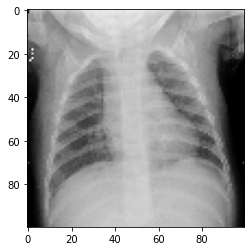

In [102]:
plt.imshow(image_3)
plt.savefig('../images/third_image')

In [103]:
image_3_expanded = np.expand_dims(image_3,axis=0)

In [104]:
image_3_expanded[0].shape

(100, 100, 3)

In [105]:
model_4.predict(image_3_expanded)

array([[0.615221  , 0.37168157]], dtype=float32)

Let's get the explanation of the 3rd image.

In [106]:
explanation_3 = explainer.explain_instance(image_3_expanded[0].astype('double'), model_3.predict,
                                         top_labels=5, hide_color=0, num_samples = 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

As explanined previously, the image below shows the top 2 pixels that explain the NORMAL category.

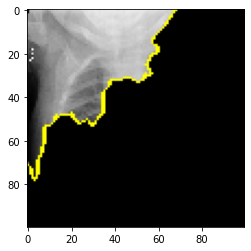

In [107]:
temp, mask = explanation_3.get_image_and_mask(explanation_3.top_labels[0], positive_only=True, num_features=2,
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/third_image_top_pixels_blackened')

This image is same as above but shows the full image.

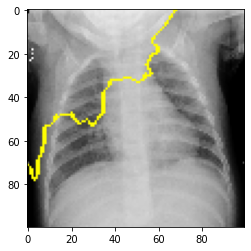

In [108]:
temp, mask = explanation_3.get_image_and_mask(explanation_3.top_labels[0], positive_only=True, num_features=2, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/third_image_top_pixels_unblackened')

This image below shows the pros and cons of pixels explaining the category.

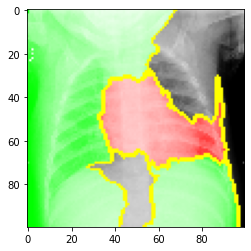

In [109]:
temp, mask = explanation_3.get_image_and_mask(explanation_3.top_labels[0], 
                                            positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig('../images/third_image_pros_cons')

Finally, This is the heatmap of the explanation weights with blue being the most heavy and red being the least heavy.

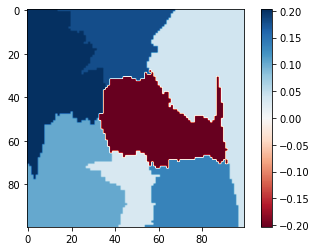

In [110]:
ind =  explanation_3.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_3.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_3.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.savefig('../images/third_image_heatmap')

## Conclusion ##

After evaluating all of our models, we can say that our best performing model is model 3. Although our runtime was significantly longer than our first 2 models, there was no significant overifitting compared to our first 2 models. Hence choosing model 3 as our best performing mode1.

A few things that we could do for future tuning is verify the accuracy of the images in the different directories of the original datasets. That could be a reason for the drop of recall score when validating the model. 